In [47]:
# %matplotlib inline
# import matplotlib
# matplotlib.use('TkAgg')  # or TkAgg, WebAgg, Qt5Agg if needed
import numpy as np
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D  # Required even if unused directly
import os
import gzip
import requests
import urllib.request
from bs4 import BeautifulSoup
from sunpy.map import Map
from sunpy.coordinates import sun
import pfsspy
import pfsspy.tracing as tracing
from sunpy.sun import constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy
import logging
sunpy.log.setLevel(logging.WARNING) # Set SunPy's logger to only show WARNING or above
data_dir = '/home/mnedal/data/'

In [48]:
def find_links(url='http://www.python.org'):
    """
    Get all the links in a webpage.
    Source: https://stackoverflow.com/questions/20150184/make-a-list-of-all-the-files-on-a-website
    """
    soup = BeautifulSoup(requests.get(url).text)
    hrefs = []
    for a in soup.find_all('a'):
        hrefs.append(a['href'])
    return hrefs

In [49]:
mydatetime       = '2024-05-14T17:40'
YEAR, MONTH, DAY = mydatetime.split('T')[0].split('-')
HOUR, MINUTE     = mydatetime.split('T')[1].split(':')

# show the links of the GONG files
gong_url = 'https://gong2.nso.edu/oQR/zqs/%s%s/mrzqs%s%s%s/' %(YEAR, MONTH, YEAR[-2:], MONTH, DAY)
list_gong_links = find_links(url=gong_url)

# # show what you've found
# for i, link in enumerate(list_gong_links):
#     print(i, link)

gong_file_index = 21
gong_filename = list_gong_links[gong_file_index]

if not os.path.exists(data_dir + gong_filename[:-3]) and not os.path.exists(data_dir + gong_filename):
    urllib.request.urlretrieve(url=gong_url+gong_filename, filename=data_dir+gong_filename)

if not os.path.exists(data_dir + gong_filename[:-3]):
    with gzip.open(data_dir + gong_filename, 'rb') as f:
        with open(data_dir + gong_filename[:-3], 'wb') as g:
            g.write(f.read())

# make a sunpy map of the file
gong_map = Map(data_dir + gong_filename[:-3])

# fix a bug in the GONG map file
if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = u.deg

In [50]:
# Model the PFSS field lines
nrho     = 50  # number of rho grid points
rss      = 3   # source surface radius
pfss_in  = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

num_footpoints_lat = 10
num_footpoints_lon = 30
r = 1.15*const.radius

lat = np.linspace(np.radians(-90), np.radians(90), num_footpoints_lat, endpoint=False)
lon = np.linspace(np.radians(-180), np.radians(180), num_footpoints_lon, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad

# Make a 2D grid from these 1D points 
seeds  = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
tracer = tracing.FortranTracer()
# tracer = tracing.FortranTracer(max_steps=20000, step_size=1)
field_lines = tracer.trace(seeds, pfss_out)

/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/pfsspy/output.py:95: UserWarning:

Could not parse unit string "Gauss" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.

/mnt/mnedal_data/anaconda3/envs/dias/lib/python3.10/site-packages/pfsspy/tracing.py:180: UserWarning:

At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.



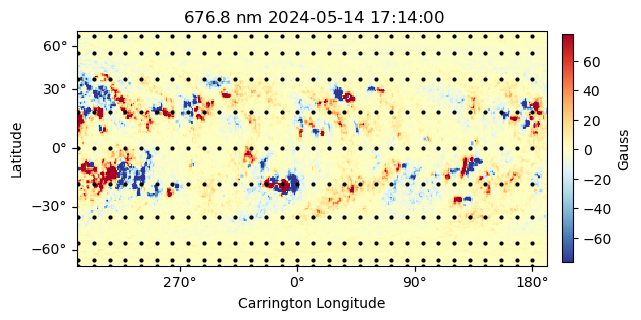

In [51]:
m   = pfss_in.map
fig = plt.figure()
ax  = plt.subplot(projection=m)
gon = m.plot(cmap='RdYlBu_r', clip_interval=[1, 99]*u.percent)
ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2)
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
plt.show()

In [6]:
# # Plot the shock shell with the Sun
# fig = plt.figure(figsize=[10,8])
# ax  = fig.add_subplot(111, projection='3d', computed_zorder=False)

# # draw the Sun
# theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
# x = np.sin(theta)*np.cos(phi) 
# y = np.sin(theta)*np.sin(phi) 
# z = np.cos(theta)
# ax.plot_surface(x, y, z, color='orange', zorder=0, label='Sun')

# # shock shell dimensions
# b_major = 0.7
# b_minor = 0.7

# # Convert to radians
# shell_lon = np.deg2rad(90)
# shell_lat = np.deg2rad(0)

# # Convert to Cartesian (unit Sun radius)
# xshift = np.cos(shell_lat) * np.cos(shell_lon)
# yshift = np.cos(shell_lat) * np.sin(shell_lon)
# zshift = np.sin(shell_lat)

# # shock shell - medium density grid for both surface and normals
# theta_src, phi_src = np.mgrid[0:np.pi:30j, 0:2*np.pi:30j]

# # oblate or prolate ellipsoidal shell
# x_src = xshift + b_minor * np.sin(theta_src)*np.cos(phi_src)
# y_src = yshift + b_minor * np.sin(theta_src)*np.sin(phi_src)
# z_src = zshift + b_major * np.cos(theta_src)

# # Remove parts of shell inside the Sun
# r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
# mask = r_shell > 1  # Keep points outside the Sun

# # Filter coordinates to only include points outside the Sun
# x_outer = x_src[mask]
# y_outer = y_src[mask]
# z_outer = z_src[mask]

# # Calculate normal vectors for the ellipsoid
# # For an ellipsoid: (x-xc)²/a² + (y-yc)²/b² + (z-zc)²/c² = 1
# # Normal vector components are: nx = 2(x-xc)/a², ny = 2(y-yc)/b², nz = 2(z-zc)/c²

# # Semi-axes of the ellipsoid
# a = b_minor  # x and y semi-axes
# b = b_minor  # x and y semi-axes  
# c = b_major  # z semi-axis

# # Calculate normal vector components for outer surface points
# nx = 2 * (x_outer - xshift) / (a**2)
# ny = 2 * (y_outer - yshift) / (b**2)
# nz = 2 * (z_outer - zshift) / (c**2)

# # Normalize the normal vectors
# norm_magnitude = np.sqrt(nx**2 + ny**2 + nz**2)
# nx_norm = nx / norm_magnitude
# ny_norm = ny / norm_magnitude
# nz_norm = nz / norm_magnitude

# # Scale normal vectors for visualization
# vector_scale = 0.2
# nx_scaled = nx_norm * vector_scale
# ny_scaled = ny_norm * vector_scale
# nz_scaled = nz_norm * vector_scale

# # Plot the shell surface using the same grid
# x_display = x_src.copy()
# y_display = y_src.copy()
# z_display = z_src.copy()

# # Remove parts inside the Sun for display
# r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
# mask_display = r_display < 1
# x_display[mask_display] = np.nan
# y_display[mask_display] = np.nan
# z_display[mask_display] = np.nan

# ax.plot_surface(x_display, y_display, z_display, cmap='inferno', alpha=0.7, zorder=20, label='Shock wave')

# # Plot normal vectors as arrows
# ax.quiver(x_outer, y_outer, z_outer, 
#           nx_scaled, ny_scaled, nz_scaled,
#           color='cyan', alpha=0.8, arrow_length_ratio=0.1, linewidth=1, zorder=100)

# # draw center of shell
# ax.plot(xshift, yshift, zshift, marker='o', markersize=5, color='black', label='Shell center')

# # Plot config
# fig_limit = 2
# ax.set_xlim(-1*fig_limit, fig_limit)
# ax.set_ylim(-1*fig_limit, fig_limit)
# ax.set_zlim(-1*fig_limit, fig_limit)
# ax.set_box_aspect([fig_limit, fig_limit, fig_limit])
# ax.legend(title='Surfaces', loc='upper right', prop={'size':8}, bbox_to_anchor=(-0.01, 1))
# ax.view_init(elev=0, azim=0)
# for axis in 'xyz':
#     getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
# fig.tight_layout()
# plt.show()

In [7]:
# find where is the Earth LOS on GONG map
hp_lon = 0*u.arcsec
hp_lat = np.linspace(-90, 90, 1)*u.arcsec

# Make a 2D grid from these 1D points
lon, lat  = np.meshgrid(hp_lon, hp_lat)
earth_los = SkyCoord(lon.ravel(), lat.ravel(), frame=gong_map.coordinate_frame)
los_lon   = sun.L0(time=gong_map.meta['date-obs']).value
print(f'Carrington longitude: {los_lon}')

fig = plt.figure()
ax  = plt.subplot(projection=gong_map)
gon = gong_map.plot(cmap='RdYlBu_r', clip_interval=[1, 99]*u.percent)

ax.plot_coord(seeds, color='crimson', marker='o', linewidth=0, markersize=2)
# ax.plot_coord(earth_los, color='k', marker='*', linewidth=0, markersize=5, label='Earth LOS')
ax.axvline(x=los_lon, color='black', linestyle='--', linewidth=2, label='Earth LOS')

ax.legend(loc='upper right', prop={'size':8}, bbox_to_anchor=(-0.01, 1))
fig.colorbar(gon, fraction=0.023, pad=0.03, label=pfss_in.map.meta['bunit'])
fig.tight_layout()
plt.show()

Carrington longitude: 260.68779881111624


In [13]:
# Make the GONG sphere surface coordinates
theta, phi = np.mgrid[0:np.pi:180j, 0:2*np.pi:360j]
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Normalize the GONG data
gong_data = gong_map.data.astype(np.float32)
gong_data = np.nan_to_num(gong_data, nan=0.0)  # Remove NaNs

# Normalize for color mapping
abs_max = np.max(np.abs(gong_data))
normed_data = (gong_data + abs_max) / (2 * abs_max)

# Choose colormap (e.g., magnetogram style)
cmap = cm.get_cmap('RdYlBu_r')  # gray, RdBu_r, RdYlBu_r, seismic, bwr for polarity
colors = cmap(normed_data)

# If you’re using a diverging colormap (e.g. 'RdBu_r'), it’s better to center the normalization around 0
abs_max = np.max(np.abs(gong_data))
norm = Normalize(vmin=-abs_max, vmax=abs_max)
norm = Normalize(vmin=gong_data.min(), vmax=gong_data.max())

mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])  # Required dummy input

# Plot
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.plot_surface(x, y, z, facecolors=colors, rstride=1, cstride=1, linewidth=0,
                    antialiased=False, shade=False, label='GONG')


# Convert Carrington (lon, lat) to spherical (theta, phi) for plotting
# phi   = longitude in radians: measured from x-axis
# theta = colatitude in radians: 0 at north pole → pi at south pole
phi = np.deg2rad(los_lon)
theta = np.pi / 2  # equator

ux = np.sin(theta) * np.cos(phi)
uy = np.sin(theta) * np.sin(phi)
uz = np.cos(theta)

# Shift starting point to 2 solar radii
start_r = 1.5
end_r   = 2  # arrow will be 0.5 R☉ long

x0, y0, z0 = start_r * ux, start_r * uy, start_r * uz
dx, dy, dz = (end_r - start_r) * ux, (end_r - start_r) * uy, (end_r - start_r) * uz

# Draw Earth LOS arrow
ax.quiver(x0, y0, z0, dx, dy, dz,
          color='k', arrow_length_ratio=0.2, linewidth=2, label='Earth LOS')

# Add colorbar
fig.colorbar(mappable, ax=ax, shrink=0.5, pad=0.1, label='Magnetic Field [G]')


# Add the PFSS lines
with tqdm(total=len(field_lines), desc='Plotting the field lines') as pbar:
    for n, field_line in enumerate(field_lines):
        color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
        coords = field_line.coords
        coords.representation_type = 'cartesian'
        x_line = coords.x/const.radius
        y_line = coords.y/const.radius
        z_line = coords.z/const.radius
        ax.plot3D(x_line, y_line, z_line, alpha=1, color=color, linewidth=1, zorder=100)
        pbar.update(1)



# Plot config
fig_limit = 2
ax.set_xlim(-1*fig_limit, fig_limit)
ax.set_ylim(-1*fig_limit, fig_limit)
ax.set_zlim(-1*fig_limit, fig_limit)
ax.set_box_aspect([fig_limit, fig_limit, fig_limit])
ax.view_init(elev=0, azim=los_lon)
ax.legend(title='Surfaces', loc='upper right', prop={'size':8}, bbox_to_anchor=(-0.01, 1))
ax.set_axis_off()
for axis in 'xyz':
    getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
fig.tight_layout()
plt.show()

/var/folders/x2/l9mvx3_j0dq_chfk9knp41780000gp/T/ipykernel_99328/3951843632.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r')  # gray, RdBu_r, RdYlBu_r, seismic, bwr for polarity
Plotting the field lines: 100%|██████████| 300/300 [00:00<00:00, 951.12it/s]


In [87]:
# # another way ...

# def geo_to_cartesian(latitude, longitude, radius=1):
#     """
#     Convert geographic coordinates to Cartesian coordinates.
#     """
#     # Convert degrees to radians
#     lat_rad = np.deg2rad(latitude)
#     lon_rad = np.deg2rad(longitude)
    
#     # Cartesian coordinates
#     x = radius * np.cos(lat_rad) * np.cos(lon_rad)
#     y = radius * np.cos(lat_rad) * np.sin(lon_rad)
#     z = radius * np.sin(lat_rad)
    
#     return x, y, z

# # Make the GONG sphere surface soordinates
# theta, phi = np.mgrid[0:np.pi:180j, 0:2*np.pi:360j]
# x = np.sin(theta) * np.cos(phi)
# y = np.sin(theta) * np.sin(phi)
# z = np.cos(theta)

# # Normalize the GONG data
# gong_data = gong_map.data.astype(np.float32)
# gong_data = np.nan_to_num(gong_data, nan=0.0)  # Remove NaNs

# # Normalize for color mapping
# # normed_data = (gong_data - gong_data.min()) / (gong_data.max() - gong_data.min())
# abs_max = np.max(np.abs(gong_data))
# normed_data = (gong_data + abs_max) / (2 * abs_max)

# # Choose colormap (e.g., magnetogram style)
# cmap = cm.get_cmap('RdYlBu_r')  # gray, RdBu_r, RdYlBu_r, seismic, bwr for polarity
# colors = cmap(normed_data)

# # Normalize the same way as you did for colors
# # norm = Normalize(vmin=gong_data_resized.min(), vmax=gong_data_resized.max())

# # If you’re using a diverging colormap (e.g. 'RdBu_r'), it’s better to center the normalization around 0
# abs_max = np.max(np.abs(gong_data_resized))
# norm = Normalize(vmin=-abs_max, vmax=abs_max)

# mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
# mappable.set_array([])  # Required dummy input

# # Plot
# fig = plt.figure(figsize=[10,8])
# ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
# ax.plot_surface(x, y, z, facecolors=colors, rstride=1, cstride=1, linewidth=0,
#                     antialiased=False, shade=False, label='GONG')




# # Define your geographic coordinates
# latitude = 0
# longitude = sun.L0(time=mydatetime).value
# ux, uy, uz = geo_to_cartesian(latitude, longitude)
# ax.quiver(0, 0, 0, ux, uy, uz, length=2, arrow_length_ratio=0.3, color='red', label='Earth LOS')




# # Add colorbar
# fig.colorbar(mappable, ax=ax, shrink=0.5, pad=0.1, label='Magnetic Field [G]')

# # Plot config
# fig_limit = 2
# ax.set_xlim(-1*fig_limit, fig_limit)
# ax.set_ylim(-1*fig_limit, fig_limit)
# ax.set_zlim(-1*fig_limit, fig_limit)
# ax.set_box_aspect([fig_limit, fig_limit, fig_limit])
# # ax.view_init(elev=0, azim=los_lon)
# ax.view_init(elev=90, azim=sun.L0(time=mydatetime).value )
# ax.legend(title='Surfaces', loc='upper right', prop={'size':8}, bbox_to_anchor=(-0.01, 1))
# ax.set_axis_off()
# for axis in 'xyz':
#     getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
# fig.tight_layout()
# plt.show()

/var/folders/x2/l9mvx3_j0dq_chfk9knp41780000gp/T/ipykernel_96615/3949655271.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r')  # gray, RdBu_r, RdYlBu_r, seismic, bwr for polarity


In [8]:
# Plot the shock shell with the Sun
fig = plt.figure(figsize=[10,8])
ax  = fig.add_subplot(111, projection='3d', computed_zorder=False)

# draw the Sun
theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
x = np.sin(theta)*np.cos(phi) 
y = np.sin(theta)*np.sin(phi) 
z = np.cos(theta)
ax.plot_surface(x, y, z, color='orange', zorder=0, label='Sun')

# shock shell dimensions
b_major = 0.7
b_minor = 0.7

# Convert the center of shock location to radians
shell_lon = np.deg2rad(0)
shell_lat = np.deg2rad(90)

# Convert to Cartesian (unit Sun radius)
xshift = np.cos(shell_lat) * np.cos(shell_lon)
yshift = np.cos(shell_lat) * np.sin(shell_lon)
zshift = np.sin(shell_lat)

# shock shell - medium density grid for both surface and normals
theta_src, phi_src = np.mgrid[0:np.pi:50j, 0:2*np.pi:50j]

# oblate or prolate ellipsoidal shell
x_src = xshift + b_minor * np.sin(theta_src)*np.cos(phi_src)
y_src = yshift + b_minor * np.sin(theta_src)*np.sin(phi_src)
z_src = zshift + b_major * np.cos(theta_src)

# Remove parts of shell inside the Sun
r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
mask    = r_shell > 1  # Keep points outside the Sun

# Filter coordinates to only include points outside the Sun
x_outer = x_src[mask]
y_outer = y_src[mask]
z_outer = z_src[mask]

# Calculate normal vectors for the ellipsoid
# For an ellipsoid: (x-xc)²/a² + (y-yc)²/b² + (z-zc)²/c² = 1
# Normal vector components are: nx = 2(x-xc)/a², ny = 2(y-yc)/b², nz = 2(z-zc)/c²

# Semi-axes of the ellipsoid
a = b_minor  # x and y semi-axes
b = b_minor  # x and y semi-axes  
c = b_major  # z semi-axis

# Calculate normal vector components for outer surface points
nx = 2 * (x_outer - xshift) / (a**2)
ny = 2 * (y_outer - yshift) / (b**2)
nz = 2 * (z_outer - zshift) / (c**2)

# Normalize the normal vectors
norm_magnitude = np.sqrt(nx**2 + ny**2 + nz**2)
nx_norm = nx / norm_magnitude
ny_norm = ny / norm_magnitude
nz_norm = nz / norm_magnitude

# Scale normal vectors for visualization
vector_scale = 0.2
nx_scaled = nx_norm * vector_scale
ny_scaled = ny_norm * vector_scale
nz_scaled = nz_norm * vector_scale

# Plot the shell surface using the same grid
x_display = x_src.copy()
y_display = y_src.copy()
z_display = z_src.copy()

# Remove parts inside the Sun for display
r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
mask_display = r_display < 1
x_display[mask_display] = np.nan
y_display[mask_display] = np.nan
z_display[mask_display] = np.nan

# Collect all magnetic field points
all_field_points  = []
all_field_vectors = []

# Plot the magnetic field lines
for n, field_line in enumerate(field_lines):
    color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(field_line.polarity)
    coords = field_line.coords
    coords.representation_type = 'cartesian'
    x_field = coords.x/const.radius
    y_field = coords.y/const.radius  
    z_field = coords.z/const.radius
    ax.plot3D(x_field, y_field, z_field, alpha=0.8, zorder=1, color=color, linewidth=1)

    # Calculate theta angles between normal vectors and magnetic field lines
    # First, we need the field_lines data, and const.radius is the solar radius unit

    # Calculate field direction vectors (tangent to field line)
    for i in range(len(x_field)-1):
        # Field point
        field_point = np.array([x_field[i], y_field[i], z_field[i]])
        all_field_points.append(field_point)
        
        # Field direction (tangent vector)
        field_vector = np.array([x_field[i+1] - x_field[i], 
                                y_field[i+1] - y_field[i], 
                                z_field[i+1] - z_field[i]])
        # Normalize field vector
        field_vector = field_vector / np.linalg.norm(field_vector)
        all_field_vectors.append(field_vector)


all_field_points  = np.array(all_field_points)
all_field_vectors = np.array(all_field_vectors)

# Calculate theta angles for each surface point
theta_angles = np.zeros_like(x_outer)

for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
    surface_point = np.array([x_pt, y_pt, z_pt])
    
    # Find closest magnetic field point
    distances   = np.linalg.norm(all_field_points - surface_point, axis=1)
    closest_idx = np.argmin(distances)
    
    # Get the magnetic field vector at closest point
    b_vector = all_field_vectors[closest_idx]
    
    # Get the normal vector at this surface point
    n_vector = np.array([nx_norm[i], ny_norm[i], nz_norm[i]])
    
    # Calculate angle between normal and magnetic field (in degrees)
    cos_theta = np.dot(n_vector, b_vector)
    # Clamp to avoid numerical errors
    cos_theta   = np.clip(cos_theta, -1, 1)
    theta_angle = np.degrees(np.arccos(np.abs(cos_theta)))  # Use absolute value for acute angle
    
    theta_angles[i] = theta_angle

# Create a 2D array for surface coloring
theta_surface = np.full_like(x_src, np.nan)
valid_indices = np.where(mask)  # Where mask is True (outside Sun)

# Map the 1D theta_angles back to 2D surface grid
for i, (row_idx, col_idx) in enumerate(zip(valid_indices[0], valid_indices[1])):
    theta_surface[row_idx, col_idx] = theta_angles[i]

# Plot the shell surface with theta angle colormap
surf = ax.plot_surface(x_display, y_display, z_display, 
                      facecolors=plt.cm.viridis(theta_surface/90),  # Normalize to 0-90 degrees
                      alpha=0.8, zorder=20, label='Shock wave')

# Add colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=90))
mappable.set_array(theta_angles)
cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, aspect=20)
cbar.set_label('Theta Angle (degrees)', rotation=270, labelpad=15)

# Plot normal vectors as arrows
# ax.quiver(x_outer, y_outer, z_outer, 
#           nx_scaled, ny_scaled, nz_scaled,
#           color='white', alpha=0.3, arrow_length_ratio=0.1, linewidth=0.5)

# draw center of shell
ax.plot(xshift, yshift, zshift, marker='o', markersize=5, color='black', label='Shell center')

# Plot config
fig_limit = 2
ax.set_xlim(-1*fig_limit, fig_limit)
ax.set_ylim(-1*fig_limit, fig_limit)
ax.set_zlim(-1*fig_limit, fig_limit)
ax.set_box_aspect([fig_limit, fig_limit, fig_limit])
ax.legend(title='Surfaces', loc='upper right', prop={'size':8}, bbox_to_anchor=(-0.01, 1))
ax.view_init(elev=0, azim=0)
ax.set_axis_off()
# for axis in 'xyz':
#     getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')
fig.tight_layout()
plt.show()

# Print some statistics for verification
print(f"Theta angle statistics:")
print(f"Min angle: {np.min(theta_angles):.1f}°")
print(f"Max angle: {np.max(theta_angles):.1f}°")
print(f"Mean angle: {np.mean(theta_angles):.1f}°")
print(f"Expected: angles should be close to 90° since radial lines are roughly perpendicular to ellipsoid surface")

Theta angle statistics:
Min angle: 0.7°
Max angle: 89.9°
Mean angle: 28.8°
Expected: angles should be close to 90° since radial lines are roughly perpendicular to ellipsoid surface


Test version, sanity check

In [14]:
# === TEST VERSION ===

# Plot the shock shell with the Sun
fig = plt.figure(figsize=[12,8])
ax  = fig.add_subplot(111, projection='3d', computed_zorder=False)

# draw the Sun
theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
x = np.sin(theta)*np.cos(phi) 
y = np.sin(theta)*np.sin(phi) 
z = np.cos(theta)
ax.plot_surface(x, y, z, color='orange', zorder=0, label='Sun')

# shock shell dimensions
b_major = 0.7
b_minor = 0.7

# Convert to radians
shell_lon = np.deg2rad(90)
shell_lat = np.deg2rad(0)

# Convert to Cartesian (unit Sun radius)
xshift = np.cos(shell_lat) * np.cos(shell_lon)
yshift = np.cos(shell_lat) * np.sin(shell_lon)
zshift = np.sin(shell_lat)

# shock shell - medium density grid for both surface and normals
theta_src, phi_src = np.mgrid[0:np.pi:50j, 0:2*np.pi:50j]

# oblate or prolate ellipsoidal shell
x_src = xshift + b_minor * np.sin(theta_src)*np.cos(phi_src)
y_src = yshift + b_minor * np.sin(theta_src)*np.sin(phi_src)
z_src = zshift + b_major * np.cos(theta_src)

# Remove parts of shell inside the Sun
r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
mask = r_shell > 1  # Keep points outside the Sun

# Filter coordinates to only include points outside the Sun
x_outer = x_src[mask]
y_outer = y_src[mask]
z_outer = z_src[mask]

# Calculate normal vectors for the ellipsoid
# For an ellipsoid: (x-xc)²/a² + (y-yc)²/b² + (z-zc)²/c² = 1
# Normal vector components are: nx = 2(x-xc)/a², ny = 2(y-yc)/b², nz = 2(z-zc)/c²

# Semi-axes of the ellipsoid
a = b_minor  # x and y semi-axes
b = b_minor  # x and y semi-axes  
c = b_major  # z semi-axis

# Calculate normal vector components for outer surface points
nx = 2 * (x_outer - xshift) / (a**2)
ny = 2 * (y_outer - yshift) / (b**2)
nz = 2 * (z_outer - zshift) / (c**2)

# Normalize the normal vectors
norm_magnitude = np.sqrt(nx**2 + ny**2 + nz**2)
nx_norm = nx / norm_magnitude
ny_norm = ny / norm_magnitude
nz_norm = nz / norm_magnitude

# Scale normal vectors for visualization
vector_scale = 0.2
nx_scaled = nx_norm * vector_scale
ny_scaled = ny_norm * vector_scale
nz_scaled = nz_norm * vector_scale

# Plot the shell surface using the same grid
x_display = x_src.copy()
y_display = y_src.copy()
z_display = z_src.copy()

# Remove parts inside the Sun for display
r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
mask_display = r_display < 1
x_display[mask_display] = np.nan
y_display[mask_display] = np.nan
z_display[mask_display] = np.nan

# CREATE RADIAL LINES FROM SUN CENTER
# Generate radial directions (similar density to surface grid)
theta_radial, phi_radial = np.mgrid[0:np.pi:30j, 0:2*np.pi:30j]

# Create radial unit vectors
radial_dirs_x = np.sin(theta_radial) * np.cos(phi_radial)
radial_dirs_y = np.sin(theta_radial) * np.sin(phi_radial)
radial_dirs_z = np.cos(theta_radial)

# Flatten for easier processing
radial_dirs_x_flat = radial_dirs_x.flatten()
radial_dirs_y_flat = radial_dirs_y.flatten()
radial_dirs_z_flat = radial_dirs_z.flatten()

# Create radial lines from Sun center (0,0,0) to 3 solar radii
radial_length = 3
all_radial_points = []
all_radial_vectors = []

# Plot radial lines and collect data
for i in range(len(radial_dirs_x_flat)):
    # Radial direction
    r_dir = np.array([radial_dirs_x_flat[i], radial_dirs_y_flat[i], radial_dirs_z_flat[i]])
    
    # Create points along this radial line
    radial_points = np.linspace(0, radial_length, 50)  # 50 points along each line
    
    line_x = radial_points * r_dir[0]
    line_y = radial_points * r_dir[1] 
    line_z = radial_points * r_dir[2]
    
    # Plot the radial line
    ax.plot3D(line_x, line_y, line_z, color='gray', alpha=1, linewidth=1)
    
    # Store points and vectors for angle calculation
    for j in range(len(radial_points)-1):
        point = np.array([line_x[j], line_y[j], line_z[j]])
        all_radial_points.append(point)
        # Radial direction is the same for all points on this line
        all_radial_vectors.append(r_dir)

all_radial_points = np.array(all_radial_points)
all_radial_vectors = np.array(all_radial_vectors)

# Calculate theta angles between normal vectors and radial lines
theta_angles = np.zeros_like(x_outer)

for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
    surface_point = np.array([x_pt, y_pt, z_pt])
    
    # Find closest radial line point
    distances = np.linalg.norm(all_radial_points - surface_point, axis=1)
    closest_idx = np.argmin(distances)
    
    # Get the radial direction vector at closest point
    radial_vector = all_radial_vectors[closest_idx]
    
    # Get the normal vector at this surface point
    n_vector = np.array([nx_norm[i], ny_norm[i], nz_norm[i]])
    
    # Calculate angle between normal and radial direction (in degrees)
    cos_theta = np.dot(n_vector, radial_vector)
    # Clamp to avoid numerical errors
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta_angle = np.degrees(np.arccos(np.abs(cos_theta)))  # Use absolute value for acute angle
    
    theta_angles[i] = theta_angle

# Create a 2D array for surface coloring
theta_surface = np.full_like(x_src, np.nan)
valid_indices = np.where(mask)  # Where mask is True (outside Sun)

# Map the 1D theta_angles back to 2D surface grid
for i, (row_idx, col_idx) in enumerate(zip(valid_indices[0], valid_indices[1])):
    theta_surface[row_idx, col_idx] = theta_angles[i]

# Plot the shell surface with theta angle colormap
surf = ax.plot_surface(x_display, y_display, z_display, 
                      facecolors=plt.cm.viridis(theta_surface/90.0),  # Normalize to 0-90 degrees
                      alpha=0.8, zorder=20, label='Shock wave')

# Add colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=90))
mappable.set_array(theta_angles)
cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, aspect=20)
cbar.set_label('Theta Angle (degrees)', rotation=270, labelpad=15)

# Plot normal vectors as arrows (optional - you might want to remove this for clarity)
ax.quiver(x_outer, y_outer, z_outer, 
          nx_scaled, ny_scaled, nz_scaled,
          color='k', alpha=1, arrow_length_ratio=0.1, linewidth=1, zorder=100)

# draw center of shell
ax.plot(xshift, yshift, zshift, marker='o', markersize=5, color='black', label='Shell center')

# Plot config
fig_limit = 2
ax.set_xlim(-1*fig_limit, fig_limit)
ax.set_ylim(-1*fig_limit, fig_limit)
ax.set_zlim(-1*fig_limit, fig_limit)
ax.set_box_aspect([fig_limit, fig_limit, fig_limit])
ax.legend(title='Surfaces', loc='upper right', prop={'size':8}, bbox_to_anchor=(-0.01, 1))
ax.view_init(elev=0, azim=0)
ax.set_axis_off()
# for axis in 'xyz':
#     getattr(ax, 'set_{}label'.format(axis))(axis+' [R$_\odot]$')

# Add title for clarity
ax.set_title('Test: Theta angles between shell normals and radial lines')
fig.tight_layout()
plt.show()

# Print some statistics for verification
print(f"Theta angle statistics:")
print(f"Min angle: {np.min(theta_angles):.1f}°")
print(f"Max angle: {np.max(theta_angles):.1f}°")
print(f"Mean angle: {np.mean(theta_angles):.1f}°")
print(f"Expected: angles should be close to 90° since radial lines are roughly perpendicular to ellipsoid surface")

Theta angle statistics:
Min angle: 1.8°
Max angle: 74.0°
Mean angle: 46.3°
Expected: angles should be close to 90° since radial lines are roughly perpendicular to ellipsoid surface


# Test with slide bars

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_interactive_shell(n_lon_radial=30, n_lat_radial=30,
                           radial_length=3,
                           shell_lon_deg=90, shell_lat_deg=0,
                           b_major=0.7, b_minor=0.7,
                           shell_mesh_res=50,
                           elev=0, azim=0,
                           show_radials=True, show_normals=True, show_shell=True):

    # Clear previous plots
    plt.close('all')

    fig = plt.figure(figsize=[10,8])
    ax  = fig.add_subplot(111, projection='3d', computed_zorder=False)

    # draw the Sun
    theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    ax.plot_surface(x, y, z, color='orange', zorder=0, alpha=1)

    # Convert shell center position to radians
    shell_lon = np.deg2rad(shell_lon_deg)
    shell_lat = np.deg2rad(shell_lat_deg)

    xshift = np.cos(shell_lat) * np.cos(shell_lon)
    yshift = np.cos(shell_lat) * np.sin(shell_lon)
    zshift = np.sin(shell_lat)
    
    theta_src, phi_src = np.mgrid[0:np.pi:complex(shell_mesh_res), 0:2*np.pi:complex(shell_mesh_res)]
    x_src = xshift + b_minor * np.sin(theta_src)*np.cos(phi_src)
    y_src = yshift + b_minor * np.sin(theta_src)*np.sin(phi_src)
    z_src = zshift + b_major * np.cos(theta_src)

    r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
    mask = r_shell > 1
    x_outer = x_src[mask]
    y_outer = y_src[mask]
    z_outer = z_src[mask]

    a, b, c = b_minor, b_minor, b_major
    nx = 2 * (x_outer - xshift) / (a**2)
    ny = 2 * (y_outer - yshift) / (b**2)
    nz = 2 * (z_outer - zshift) / (c**2)
    norm = np.sqrt(nx**2 + ny**2 + nz**2)
    nx /= norm
    ny /= norm
    nz /= norm

    # Grid for display (NaN inside the Sun)
    x_display = np.copy(x_src)
    y_display = np.copy(y_src)
    z_display = np.copy(z_src)
    r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
    x_display[r_display < 1] = np.nan
    y_display[r_display < 1] = np.nan
    z_display[r_display < 1] = np.nan

    # Radial directions
    # Always define these — needed for theta angle calculations
    all_points = []
    all_dirs   = []

    if show_radials:
        theta_radial, phi_radial = np.mgrid[0:np.pi:complex(n_lat_radial), 0:2*np.pi:complex(n_lon_radial)]
        rdx = np.sin(theta_radial) * np.cos(phi_radial)
        rdy = np.sin(theta_radial) * np.sin(phi_radial)
        rdz = np.cos(theta_radial)
        rdx_flat = rdx.flatten()
        rdy_flat = rdy.flatten()
        rdz_flat = rdz.flatten()
        
        for i in range(len(rdx_flat)):
            r_vec = np.array([rdx_flat[i], rdy_flat[i], rdz_flat[i]])
            r_pts = np.linspace(0, radial_length, 50)
            lx = r_pts * r_vec[0]
            ly = r_pts * r_vec[1]
            lz = r_pts * r_vec[2]
            ax.plot3D(lx, ly, lz, color='gray', linewidth=1)
            for j in range(len(r_pts)-1):
                all_points.append([lx[j], ly[j], lz[j]])
                all_dirs.append(r_vec)
    
    # Convert to arrays for downstream use
    all_points = np.array(all_points)
    all_dirs   = np.array(all_dirs)

    # Angle θ between normal and radial direction
    theta_angles = np.zeros_like(x_outer)

    if len(all_points) > 0:
        for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
            surf_pt = np.array([x_pt, y_pt, z_pt])
            dists = np.linalg.norm(all_points - surf_pt, axis=1)
            idx = np.argmin(dists)
            radial_dir = all_dirs[idx]
            n_vec = np.array([nx[i], ny[i], nz[i]])
            cos_theta = np.dot(n_vec, radial_dir)
            cos_theta = np.clip(cos_theta, -1.0, 1.0)
            theta_angles[i] = np.degrees(np.arccos(np.abs(cos_theta)))
    else:
        theta_angles[:] = np.nan  # No radial directions = undefined angles

    # Map θ to surface
    theta_surface = np.full_like(x_src, np.nan)
    valid = np.where(mask)
    for i, (r_idx, c_idx) in enumerate(zip(*valid)):
        theta_surface[r_idx, c_idx] = theta_angles[i]
    
    if show_shell:
        ax.plot_surface(x_display, y_display, z_display,
                        facecolors=plt.cm.viridis(theta_surface/90),
                        alpha=0.8, zorder=5)
        ax.plot([xshift], [yshift], [zshift], marker='o', color='black', markersize=5)

        # Colorbar
        m = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=90))
        m.set_array(theta_angles)
        cbar = plt.colorbar(m, ax=ax, shrink=0.6, aspect=20)
        cbar.set_label('Theta Angle (degrees)', rotation=270, labelpad=15)

    # Optional: draw normal arrows
    if show_normals:
        ax.quiver(x_outer, y_outer, z_outer,
                nx * 0.2, ny * 0.2, nz * 0.2,
                color='black', linewidth=0.8, zorder=100)

    # Plot limits
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_box_aspect([1, 1, 1])
    ax.set_axis_off()
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()


# === SLIDERS ===
wide_slider_layout = widgets.Layout(width='800px')  # or try '800px' for super wide
widgets.interact(
    plot_interactive_shell,
    n_lon_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, 
                                   description='Radials (lon)', layout=wide_slider_layout),
    n_lat_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, 
                                   description='Radials (lat)', layout=wide_slider_layout),
    radial_length=widgets.FloatSlider(value=3, min=1, max=5, step=0.1, 
                                      description='Radial length', layout=wide_slider_layout),
    shell_lon_deg=widgets.IntSlider(value=90, min=-180, max=180, step=5, 
                                    description='Shell lon', layout=wide_slider_layout),
    shell_lat_deg=widgets.IntSlider(value=0, min=-90, max=90, step=5, 
                                    description='Shell lat', layout=wide_slider_layout),
    b_major=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, 
                                description='Shell major', layout=wide_slider_layout),
    b_minor=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, 
                                description='Shell minor', layout=wide_slider_layout),
    shell_mesh_res=widgets.IntSlider(value=50, min=10, max=200, step=5, 
                                 description='Shell mesh', layout=wide_slider_layout),
    elev=widgets.IntSlider(value=0, min=-90, max=90, step=5, 
                           description='Elev angle', layout=wide_slider_layout),
    azim=widgets.IntSlider(value=0, min=-180, max=180, step=5, 
                           description='Azim angle', layout=wide_slider_layout),
    show_radials=widgets.Checkbox(value=True, description='Show radials', layout=wide_slider_layout),
    show_shell=widgets.Checkbox(value=True, description='Show shell', layout=wide_slider_layout),
    show_normals=widgets.Checkbox(value=True, description='Show normals', layout=wide_slider_layout)
)

interactive(children=(IntSlider(value=30, description='Radials (lon)', layout=Layout(width='800px'), max=60, m…

<function __main__.plot_interactive_shell(n_lon_radial=30, n_lat_radial=30, radial_length=3, shell_lon_deg=90, shell_lat_deg=0, b_major=0.7, b_minor=0.7, shell_mesh_res=50, elev=0, azim=0, show_radials=True, show_normals=True, show_shell=True)>

In [ ]:
# # Calculate theta angles for each surface point
# theta_angles = np.zeros_like(x_outer)

# for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
#     surface_point = np.array([x_pt, y_pt, z_pt])
    
#     # Find closest magnetic field point
#     distances   = np.linalg.norm(all_field_points - surface_point, axis=1)
#     closest_idx = np.argmin(distances)
    
#     # Get the magnetic field vector at closest point
#     b_vector = all_field_vectors[closest_idx]
    
#     # Get the normal vector at this surface point
#     n_vector = np.array([nx_norm[i], ny_norm[i], nz_norm[i]])
    
#     # Calculate angle between normal and magnetic field (in degrees)
#     cos_theta = np.dot(n_vector, b_vector)
#     # Clamp to avoid numerical errors
#     cos_theta   = np.clip(cos_theta, -1, 1)
#     theta_angle = np.degrees(np.arccos(np.abs(cos_theta)))  # Use absolute value for acute angle
    
#     theta_angles[i] = theta_angle


In [26]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import ipywidgets as widgets
# from IPython.display import display, clear_output

# def plot_interactive_shell(n_lon_radial=30, n_lat_radial=30,
#                            radial_length=3,
#                            shell_lon_deg=90, shell_lat_deg=0,
#                            b_major=0.7, b_minor=0.7,
#                            shell_mesh_res=50,
#                            elev=0, azim=0,
#                            show_radials=False, show_normals=False,
#                            show_shell=False, show_field_lines=False):

#     # Clear previous plots
#     plt.close('all')

#     fig = plt.figure(figsize=[10,8])
#     ax  = fig.add_subplot(111, projection='3d', computed_zorder=False)

#     # draw the Sun
#     theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
#     x = np.sin(theta)*np.cos(phi)
#     y = np.sin(theta)*np.sin(phi)
#     z = np.cos(theta)
#     ax.plot_surface(x, y, z, color='orange', zorder=0, alpha=1)

#     # Convert shell center position to radians
#     shell_lon = np.deg2rad(shell_lon_deg)
#     shell_lat = np.deg2rad(shell_lat_deg)

#     xshift = np.cos(shell_lat) * np.cos(shell_lon)
#     yshift = np.cos(shell_lat) * np.sin(shell_lon)
#     zshift = np.sin(shell_lat)

#     theta_src, phi_src = np.mgrid[0:np.pi:complex(shell_mesh_res), 0:2*np.pi:complex(shell_mesh_res)]
#     x_src = xshift + b_minor * np.sin(theta_src)*np.cos(phi_src)
#     y_src = yshift + b_minor * np.sin(theta_src)*np.sin(phi_src)
#     z_src = zshift + b_major * np.cos(theta_src)

#     r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
#     mask = r_shell > 1
#     x_outer = x_src[mask]
#     y_outer = y_src[mask]
#     z_outer = z_src[mask]

#     a, b, c = b_minor, b_minor, b_major
#     nx = 2 * (x_outer - xshift) / (a**2)
#     ny = 2 * (y_outer - yshift) / (b**2)
#     nz = 2 * (z_outer - zshift) / (c**2)
#     norm = np.sqrt(nx**2 + ny**2 + nz**2)
#     nx /= norm
#     ny /= norm
#     nz /= norm

#     # Grid for display (NaN inside the Sun)
#     x_display = np.copy(x_src)
#     y_display = np.copy(y_src)
#     z_display = np.copy(z_src)
#     r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
#     x_display[r_display < 1] = np.nan
#     y_display[r_display < 1] = np.nan
#     z_display[r_display < 1] = np.nan

#     # Radial directions
#     # Always define these — needed for theta angle calculations
#     all_points = []
#     all_dirs   = []

#     if show_radials:
#         theta_radial, phi_radial = np.mgrid[0:np.pi:complex(n_lat_radial), 0:2*np.pi:complex(n_lon_radial)]
#         rdx = np.sin(theta_radial) * np.cos(phi_radial)
#         rdy = np.sin(theta_radial) * np.sin(phi_radial)
#         rdz = np.cos(theta_radial)
#         rdx_flat = rdx.flatten()
#         rdy_flat = rdy.flatten()
#         rdz_flat = rdz.flatten()
        
#         for i in range(len(rdx_flat)):
#             r_vec = np.array([rdx_flat[i], rdy_flat[i], rdz_flat[i]])
#             r_pts = np.linspace(0, radial_length, 50)
#             lx = r_pts * r_vec[0]
#             ly = r_pts * r_vec[1]
#             lz = r_pts * r_vec[2]
#             ax.plot3D(lx, ly, lz, color='gray', linewidth=1)
#             for j in range(len(r_pts)-1):
#                 all_points.append([lx[j], ly[j], lz[j]])
#                 all_dirs.append(r_vec)
        
#         # Convert to arrays for downstream use
#         all_points = np.array(all_points)
#         all_dirs   = np.array(all_dirs)
    
    
#     # Plot the magnetic field lines
#     if show_field_lines:
#         for n, field_line in enumerate(field_lines):
#             color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(field_line.polarity)
#             coords = field_line.coords
#             coords.representation_type = 'cartesian'
#             x_field = coords.x/const.radius
#             y_field = coords.y/const.radius  
#             z_field = coords.z/const.radius
#             ax.plot3D(x_field, y_field, z_field, alpha=0.8, zorder=1, color=color, linewidth=1)

#         # Calculate theta angles between normal vectors and magnetic field lines
#         # First, we need the field_lines data, and const.radius is the solar radius unit

#         # Calculate field direction vectors (tangent to field line)
#         for i in range(len(x_field)-1):
#             # Field point
#             field_point = np.array([x_field[i], y_field[i], z_field[i]])
#             all_points.append(field_point)

#             # Field direction (tangent vector)
#             field_vector = np.array([x_field[i+1] - x_field[i], 
#                                     y_field[i+1] - y_field[i], 
#                                     z_field[i+1] - z_field[i]])
#             # Normalize field vector
#             field_vector = field_vector / np.linalg.norm(field_vector)
#             all_dirs.append(field_vector)

#         # Convert to arrays for downstream use
#         all_points = np.array(all_points)
#         all_dirs   = np.array(all_dirs)


#     # Angle θ between normal and radial direction
#     theta_angles = np.zeros_like(x_outer)

#     if len(all_points) > 0:
#         for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
#             surf_pt = np.array([x_pt, y_pt, z_pt])
#             dists = np.linalg.norm(all_points - surf_pt, axis=1)
#             idx = np.argmin(dists)
#             radial_dir = all_dirs[idx]
#             n_vec = np.array([nx[i], ny[i], nz[i]])
#             cos_theta = np.dot(n_vec, radial_dir)
#             cos_theta = np.clip(cos_theta, -1.0, 1.0)
#             theta_angles[i] = np.degrees(np.arccos(np.abs(cos_theta)))
#     else:
#         theta_angles[:] = np.nan  # No radial directions = undefined angles

#     # Map θ to surface
#     theta_surface = np.full_like(x_src, np.nan)
#     valid = np.where(mask)
#     for i, (r_idx, c_idx) in enumerate(zip(*valid)):
#         theta_surface[r_idx, c_idx] = theta_angles[i]
    
#     if show_shell:
#         ax.plot_surface(x_display, y_display, z_display,
#                         facecolors=plt.cm.viridis(theta_surface/90),
#                         alpha=0.8, zorder=5)
#         ax.plot([xshift], [yshift], [zshift], marker='o', color='black', markersize=5)

#         # Colorbar
#         m = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=90))
#         m.set_array(theta_angles)
#         cbar = plt.colorbar(m, ax=ax, shrink=0.6, aspect=20)
#         cbar.set_label('Theta Angle (degrees)', rotation=270, labelpad=15)

#     # Optional: draw normal arrows
#     if show_normals:
#         ax.quiver(x_outer, y_outer, z_outer,
#                 nx * 0.2, ny * 0.2, nz * 0.2,
#                 color='black', linewidth=0.8, zorder=100)

#     # Plot limits
#     ax.set_xlim([-2, 2])
#     ax.set_ylim([-2, 2])
#     ax.set_zlim([-2, 2])
#     ax.set_box_aspect([1, 1, 1])
#     ax.set_axis_off()
#     ax.view_init(elev=elev, azim=azim)
#     plt.tight_layout()
#     plt.show()


# # === SLIDERS ===
# wide_slider_layout = widgets.Layout(width='800px')  # or try '800px' for super wide
# widgets.interact(
#     plot_interactive_shell,
#     n_lon_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, 
#                                    description='Radials (lon)', layout=wide_slider_layout),
#     n_lat_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, 
#                                    description='Radials (lat)', layout=wide_slider_layout),
#     radial_length=widgets.FloatSlider(value=3, min=1, max=5, step=0.1, 
#                                       description='Radial length', layout=wide_slider_layout),
#     shell_lon_deg=widgets.IntSlider(value=90, min=-180, max=180, step=5, 
#                                     description='Shell lon', layout=wide_slider_layout),
#     shell_lat_deg=widgets.IntSlider(value=0, min=-90, max=90, step=5, 
#                                     description='Shell lat', layout=wide_slider_layout),
#     b_major=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, 
#                                 description='Shell major', layout=wide_slider_layout),
#     b_minor=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, 
#                                 description='Shell minor', layout=wide_slider_layout),
#     shell_mesh_res=widgets.IntSlider(value=50, min=10, max=200, step=10, 
#                                  description='Shell mesh', layout=wide_slider_layout),
#     elev=widgets.IntSlider(value=0, min=-90, max=90, step=5, 
#                            description='Elev angle', layout=wide_slider_layout),
#     azim=widgets.IntSlider(value=0, min=-180, max=180, step=5, 
#                            description='Azim angle', layout=wide_slider_layout),
#     # show_radials=widgets.Checkbox(value=False, description='Show radials', layout=wide_slider_layout),
#     # show_shell=widgets.Checkbox(value=False, description='Show shell', layout=wide_slider_layout),
#     # show_normals=widgets.Checkbox(value=False, description='Show normals', layout=wide_slider_layout),
#     # show_field_lines=widgets.Checkbox(value=False, description='Show PFSS', layout=wide_slider_layout)

# )

# from functools import partial

# # Create sliders first
# slider_kwargs = dict(
#     n_lon_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lon)', layout=wide_slider_layout),
#     n_lat_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lat)', layout=wide_slider_layout),
#     radial_length=widgets.FloatSlider(value=3, min=1, max=5, step=0.1, description='Radial length', layout=wide_slider_layout),
#     shell_lon_deg=widgets.IntSlider(value=90, min=-180, max=180, step=5, description='Shell lon', layout=wide_slider_layout),
#     shell_lat_deg=widgets.IntSlider(value=0, min=-90, max=90, step=5, description='Shell lat', layout=wide_slider_layout),
#     b_major=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell major', layout=wide_slider_layout),
#     b_minor=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell minor', layout=wide_slider_layout),
#     shell_mesh_res=widgets.IntSlider(value=50, min=10, max=200, step=10, description='Shell mesh', layout=wide_slider_layout),
#     elev=widgets.IntSlider(value=0, min=-90, max=90, step=5, description='Elev angle', layout=wide_slider_layout),
#     azim=widgets.IntSlider(value=0, min=-180, max=180, step=5, description='Azim angle', layout=wide_slider_layout),
# )

# # Define checkboxes (small layout)
# cb_show_radials = widgets.Checkbox(value=False, description='Show radials')
# cb_show_shell = widgets.Checkbox(value=False, description='Show shell')
# cb_show_normals = widgets.Checkbox(value=False, description='Show normals')
# cb_show_field_lines = widgets.Checkbox(value=False, description='Show PFSS')

# checkboxes_box = widgets.HBox([cb_show_radials, cb_show_shell, cb_show_normals, cb_show_field_lines])

# # Wrap plot function with interactive
# ui = widgets.VBox([
#     widgets.VBox(list(slider_kwargs.values())),
#     checkboxes_box
# ])

# out = widgets.interactive_output(
#     plot_interactive_shell,
#     {
#         **slider_kwargs,
#         'show_radials': cb_show_radials,
#         'show_shell': cb_show_shell,
#         'show_normals': cb_show_normals,
#         'show_field_lines': cb_show_field_lines
#     }
# )

# display(ui, out)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_interactive_shell(n_lon_radial=30, n_lat_radial=30,
                           radial_length=3,
                           shell_lon_deg=90, shell_lat_deg=0,
                           b_major=0.7, b_minor=0.7,
                           shell_mesh_res=50,
                           elev=0, azim=0,
                           show_radials=False, show_normals=False,
                           show_shell=False, show_field_lines=False,
                           show_axes=True):

    # Clear previous plots
    plt.close('all')

    fig = plt.figure(figsize=[10,8])
    ax  = fig.add_subplot(111, projection='3d', computed_zorder=False)

    # draw the Sun
    theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    ax.plot_surface(x, y, z, color='orange', zorder=0, alpha=1)

    # Convert shell center position to radians
    shell_lon = np.deg2rad(shell_lon_deg)
    shell_lat = np.deg2rad(shell_lat_deg)

    xshift = np.cos(shell_lat) * np.cos(shell_lon)
    yshift = np.cos(shell_lat) * np.sin(shell_lon)
    zshift = np.sin(shell_lat)

    theta_src, phi_src = np.mgrid[0:np.pi:complex(shell_mesh_res), 0:2*np.pi:complex(shell_mesh_res)]
    x_src = xshift + b_minor * np.sin(theta_src)*np.cos(phi_src)
    y_src = yshift + b_minor * np.sin(theta_src)*np.sin(phi_src)
    z_src = zshift + b_major * np.cos(theta_src)

    r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
    mask = r_shell > 1
    x_outer = x_src[mask]
    y_outer = y_src[mask]
    z_outer = z_src[mask]

    a, b, c = b_minor, b_minor, b_major
    nx = 2 * (x_outer - xshift) / (a**2)
    ny = 2 * (y_outer - yshift) / (b**2)
    nz = 2 * (z_outer - zshift) / (c**2)
    norm = np.sqrt(nx**2 + ny**2 + nz**2)
    nx /= norm
    ny /= norm
    nz /= norm

    # Grid for display (NaN inside the Sun)
    x_display = np.copy(x_src)
    y_display = np.copy(y_src)
    z_display = np.copy(z_src)
    r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
    x_display[r_display < 1] = np.nan
    y_display[r_display < 1] = np.nan
    z_display[r_display < 1] = np.nan

    # Radial directions
    # Always define these — needed for theta angle calculations
    all_points = []
    all_dirs   = []

    if show_radials:
        theta_radial, phi_radial = np.mgrid[0:np.pi:complex(n_lat_radial), 0:2*np.pi:complex(n_lon_radial)]
        rdx = np.sin(theta_radial) * np.cos(phi_radial)
        rdy = np.sin(theta_radial) * np.sin(phi_radial)
        rdz = np.cos(theta_radial)
        rdx_flat = rdx.flatten()
        rdy_flat = rdy.flatten()
        rdz_flat = rdz.flatten()
        
        for i in range(len(rdx_flat)):
            r_vec = np.array([rdx_flat[i], rdy_flat[i], rdz_flat[i]])
            r_pts = np.linspace(0, radial_length, 50)
            lx = r_pts * r_vec[0]
            ly = r_pts * r_vec[1]
            lz = r_pts * r_vec[2]
            ax.plot3D(lx, ly, lz, color='gray', linewidth=1)
            for j in range(len(r_pts)-1):
                all_points.append([lx[j], ly[j], lz[j]])
                all_dirs.append(r_vec)
        
        # Convert to arrays for downstream use
        all_points = np.array(all_points)
        all_dirs   = np.array(all_dirs)
    
    
    # Plot the magnetic field lines
    if show_field_lines:
        for n, field_line in enumerate(field_lines):
            color = {0:'black', -1:'tab:blue', 1:'tab:red'}.get(field_line.polarity)
            coords = field_line.coords
            coords.representation_type = 'cartesian'
            x_field = coords.x/const.radius
            y_field = coords.y/const.radius  
            z_field = coords.z/const.radius
            ax.plot3D(x_field, y_field, z_field, alpha=0.8, zorder=1, color=color, linewidth=1)

        # Calculate theta angles between normal vectors and magnetic field lines
        # First, we need the field_lines data, and const.radius is the solar radius unit

        # Calculate field direction vectors (tangent to field line)
        for i in range(len(x_field)-1):
            # Field point
            field_point = np.array([x_field[i], y_field[i], z_field[i]])
            all_points.append(field_point)

            # Field direction (tangent vector)
            field_vector = np.array([x_field[i+1] - x_field[i], 
                                    y_field[i+1] - y_field[i], 
                                    z_field[i+1] - z_field[i]])
            # Normalize field vector
            field_vector = field_vector / np.linalg.norm(field_vector)
            all_dirs.append(field_vector)

        # Convert to arrays for downstream use
        all_points = np.array(all_points)
        all_dirs   = np.array(all_dirs)


    # Angle θ between normal and radial direction
    theta_angles = np.zeros_like(x_outer)

    if len(all_points) > 0:
        for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
            surf_pt = np.array([x_pt, y_pt, z_pt])
            dists = np.linalg.norm(all_points - surf_pt, axis=1)
            idx = np.argmin(dists)
            radial_dir = all_dirs[idx]
            n_vec = np.array([nx[i], ny[i], nz[i]])
            cos_theta = np.dot(n_vec, radial_dir)
            cos_theta = np.clip(cos_theta, -1.0, 1.0)
            theta_angles[i] = np.degrees(np.arccos(np.abs(cos_theta)))
    else:
        theta_angles[:] = np.nan  # No radial directions = undefined angles

    # Map θ to surface
    theta_surface = np.full_like(x_src, np.nan)
    valid = np.where(mask)
    for i, (r_idx, c_idx) in enumerate(zip(*valid)):
        theta_surface[r_idx, c_idx] = theta_angles[i]
    
    if show_shell:
        ax.plot_surface(x_display, y_display, z_display,
                        facecolors=plt.cm.viridis(theta_surface/90),
                        alpha=1, zorder=5)
        ax.plot([xshift], [yshift], [zshift], marker='o', color='black', markersize=5)

        # Colorbar
        m = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=90))
        m.set_array(theta_angles)
        cbar = plt.colorbar(m, ax=ax, shrink=0.6, aspect=20)
        cbar.set_label('Theta Angle (degrees)', rotation=270, labelpad=15)

    # Optional: draw normal arrows
    if show_normals:
        ax.quiver(x_outer, y_outer, z_outer,
                nx * 0.2, ny * 0.2, nz * 0.2,
                color='black', linewidth=0.8, zorder=100)

    # Plot limits
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_box_aspect([1, 1, 1])
    if not show_axes:
        ax.set_axis_off()
    ax.view_init(elev=elev, azim=azim)
    fig.tight_layout()
    plt.show()


# === SLIDERS ===
wide_slider_layout = widgets.Layout(width='800px')  # or try '800px' for super wide

# Create sliders first
slider_kwargs = dict(
    n_lon_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lon)', layout=wide_slider_layout),
    n_lat_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lat)', layout=wide_slider_layout),
    radial_length=widgets.FloatSlider(value=3, min=1, max=5, step=0.1, description='Radial length', layout=wide_slider_layout),
    shell_lon_deg=widgets.IntSlider(value=90, min=-180, max=180, step=5, description='Shell lon', layout=wide_slider_layout),
    shell_lat_deg=widgets.IntSlider(value=0, min=-90, max=90, step=5, description='Shell lat', layout=wide_slider_layout),
    b_major=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell major', layout=wide_slider_layout),
    b_minor=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell minor', layout=wide_slider_layout),
    shell_mesh_res=widgets.IntSlider(value=50, min=10, max=200, step=10, description='Shell mesh', layout=wide_slider_layout),
    elev=widgets.IntSlider(value=0, min=-90, max=90, step=5, description='Elev angle', layout=wide_slider_layout),
    azim=widgets.IntSlider(value=0, min=-180, max=180, step=5, description='Azim angle', layout=wide_slider_layout),
)

# Define checkboxes (small layout)
checkbox_layout = widgets.Layout(width='160px', margin='0 5px 0 0')  # top, right, bottom, left
cb_show_radials = widgets.Checkbox(value=False, description='Lines', layout=checkbox_layout)
cb_show_shell = widgets.Checkbox(value=False, description='Shell', layout=checkbox_layout)
cb_show_normals = widgets.Checkbox(value=False, description='Normals', layout=checkbox_layout)
cb_show_field_lines = widgets.Checkbox(value=False, description='PFSS', layout=checkbox_layout)
cb_show_axes = widgets.Checkbox(value=False, description='Axes', layout=checkbox_layout)

checkboxes_box = widgets.HBox([cb_show_radials, cb_show_shell, cb_show_normals, cb_show_field_lines, cb_show_axes])

# Wrap plot function with interactive
ui = widgets.VBox([
    widgets.VBox(list(slider_kwargs.values())),
    checkboxes_box
])

out = widgets.interactive_output(
    plot_interactive_shell,
    {
        **slider_kwargs,
        'show_radials': cb_show_radials,
        'show_shell': cb_show_shell,
        'show_normals': cb_show_normals,
        'show_field_lines': cb_show_field_lines,
        'show_axes': cb_show_axes
    }
)

display(ui, out)

Output()

In [28]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
from functools import partial

def plot_interactive_shell(n_lon_radial=30, n_lat_radial=30,
                         radial_length=3,
                         shell_lon_deg=90, shell_lat_deg=0,
                         b_major=0.7, b_minor=0.7,
                         shell_mesh_res=50,
                         elev=0, azim=0,
                         show_radials=False, show_normals=False,
                         show_shell=False, show_field_lines=False,
                         show_axes=True):
    
    # Create figure
    fig = go.Figure()

    # Draw the Sun
    theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    
    fig.add_trace(go.Surface(
        x=x, y=y, z=z,
        colorscale=[[0, 'orange'], [1, 'orange']],
        showscale=False,
        opacity=1,
        name='Sun'
    ))

    # Convert shell center position to radians
    shell_lon = np.deg2rad(shell_lon_deg)
    shell_lat = np.deg2rad(shell_lat_deg)

    xshift = np.cos(shell_lat) * np.cos(shell_lon)
    yshift = np.cos(shell_lat) * np.sin(shell_lon)
    zshift = np.sin(shell_lat)

    theta_src, phi_src = np.mgrid[0:np.pi:complex(shell_mesh_res), 0:2*np.pi:complex(shell_mesh_res)]
    x_src = xshift + b_minor * np.sin(theta_src)*np.cos(phi_src)
    y_src = yshift + b_minor * np.sin(theta_src)*np.sin(phi_src)
    z_src = zshift + b_major * np.cos(theta_src)

    r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
    mask = r_shell > 1
    x_outer = x_src[mask]
    y_outer = y_src[mask]
    z_outer = z_src[mask]

    a, b, c = b_minor, b_minor, b_major
    nx = 2 * (x_outer - xshift) / (a**2)
    ny = 2 * (y_outer - yshift) / (b**2)
    nz = 2 * (z_outer - zshift) / (c**2)
    norm = np.sqrt(nx**2 + ny**2 + nz**2)
    nx /= norm
    ny /= norm
    nz /= norm

    # Grid for display (NaN inside the Sun)
    x_display = np.copy(x_src)
    y_display = np.copy(y_src)
    z_display = np.copy(z_src)
    r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
    x_display[r_display < 1] = np.nan
    y_display[r_display < 1] = np.nan
    z_display[r_display < 1] = np.nan

    # Radial directions
    all_points = []
    all_dirs   = []

    if show_radials:
        theta_radial, phi_radial = np.mgrid[0:np.pi:complex(n_lat_radial), 0:2*np.pi:complex(n_lon_radial)]
        rdx = np.sin(theta_radial) * np.cos(phi_radial)
        rdy = np.sin(theta_radial) * np.sin(phi_radial)
        rdz = np.cos(theta_radial)
        rdx_flat = rdx.flatten()
        rdy_flat = rdy.flatten()
        rdz_flat = rdz.flatten()
        
        for i in range(len(rdx_flat)):
            r_vec = np.array([rdx_flat[i], rdy_flat[i], rdz_flat[i]])
            r_pts = np.linspace(0, radial_length, 50)
            lx = r_pts * r_vec[0]
            ly = r_pts * r_vec[1]
            lz = r_pts * r_vec[2]
            
            fig.add_trace(go.Scatter3d(
                x=lx, y=ly, z=lz,
                mode='lines',
                line=dict(color='gray', width=2),
                opacity=0.5,
                showlegend=False
            ))
            
            for j in range(len(r_pts)-1):
                all_points.append([lx[j], ly[j], lz[j]])
                all_dirs.append(r_vec)
        
        all_points = np.array(all_points)
        all_dirs   = np.array(all_dirs)
    
    # Plot the magnetic field lines (placeholder - you'll need to add your field_lines data)
    if show_field_lines:
        for n, field_line in enumerate(field_lines):
            color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
            coords = field_line.coords
            coords.representation_type = 'cartesian'
            x_field = coords.x/const.radius
            y_field = coords.y/const.radius  
            z_field = coords.z/const.radius
            fig.add_trace(go.Scatter3d(
                x=x_field, y=y_field, z=z_field,
                mode='lines',
                line=dict(color=color, width=2),
                showlegend=False
            ))

        # Calculate theta angles between normal vectors and magnetic field lines
        # First, we need the field_lines data, and const.radius is the solar radius unit
        
        # Calculate field direction vectors (tangent to field line)
        for i in range(len(x_field)-1):
            # Field point
            field_point = np.array([x_field[i], y_field[i], z_field[i]])
            all_points.append(field_point)

            # Field direction (tangent vector)
            field_vector = np.array([x_field[i+1] - x_field[i], 
                                    y_field[i+1] - y_field[i], 
                                    z_field[i+1] - z_field[i]])
            # Normalize field vector
            field_vector = field_vector / np.linalg.norm(field_vector)
            all_dirs.append(field_vector)

        # Convert to arrays for downstream use
        all_points = np.array(all_points)
        all_dirs   = np.array(all_dirs)

    
    # Angle θ between normal and radial direction
    theta_angles = np.zeros_like(x_outer)

    if len(all_points) > 0:
        for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
            surf_pt = np.array([x_pt, y_pt, z_pt])
            dists = np.linalg.norm(all_points - surf_pt, axis=1)
            idx = np.argmin(dists)
            radial_dir = all_dirs[idx]
            n_vec = np.array([nx[i], ny[i], nz[i]])
            cos_theta = np.dot(n_vec, radial_dir)
            cos_theta = np.clip(cos_theta, -1.0, 1.0)
            theta_angles[i] = np.degrees(np.arccos(np.abs(cos_theta)))
    else:
        theta_angles[:] = np.nan

    # Map θ to surface
    theta_surface = np.full_like(x_src, np.nan)
    valid = np.where(mask)
    for i, (r_idx, c_idx) in enumerate(zip(*valid)):
        theta_surface[r_idx, c_idx] = theta_angles[i]
    
    if show_shell:
        # Create colorscale for theta angles
        colors = theta_surface/90  # Normalize to 0-1 range
        colors[~mask] = np.nan
        
        fig.add_trace(go.Surface(
            x=x_display, y=y_display, z=z_display,
            surfacecolor=colors,
            colorscale='viridis',
            cmin=0, cmax=1,
            colorbar=dict(title='Theta Angle (degrees)', 
                          tickvals=[0, 0.5, 1], 
                          ticktext=['0', '45', '90']),
            opacity=1,
            showscale=True,
            name='Shell'
        ))
        
        fig.add_trace(go.Scatter3d(
            x=[xshift], y=[yshift], z=[zshift],
            mode='markers',
            marker=dict(color='black', size=5),
            showlegend=False
        ))

    # Optional: draw normal arrows
    if show_normals:
        fig.add_trace(go.Cone(
            x=x_outer,
            y=y_outer,
            z=z_outer,
            u=nx * 0.2,
            v=ny * 0.2,
            w=nz * 0.2,
            sizemode='absolute',
            sizeref=0.1,
            showscale=False,
            colorscale=[[0, 'black'], [1, 'black']],
            anchor='tip'
        ))

    # Set layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=show_axes, range=[-2, 2]),
            yaxis=dict(visible=show_axes, range=[-2, 2]),
            zaxis=dict(visible=show_axes, range=[-2, 2]),
            aspectmode='cube',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0)
            )
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        height=720
    )

    fig.show()

# === SLIDERS ===
wide_slider_layout = widgets.Layout(width='800px')

# Create sliders first
slider_kwargs = dict(
    n_lon_radial=widgets.IntSlider(value=10, min=1, max=100, step=1, description='Radials (lon)', layout=wide_slider_layout),
    n_lat_radial=widgets.IntSlider(value=10, min=1, max=100, step=1, description='Radials (lat)', layout=wide_slider_layout),
    radial_length=widgets.FloatSlider(value=3, min=1, max=7, step=0.1, description='Radial length', layout=wide_slider_layout),
    shell_lon_deg=widgets.IntSlider(value=90, min=-180, max=180, step=1, description='Shell lon', layout=wide_slider_layout),
    shell_lat_deg=widgets.IntSlider(value=0, min=-90, max=90, step=1, description='Shell lat', layout=wide_slider_layout),
    b_major=widgets.FloatSlider(value=0.3, min=0.1, max=2, step=0.1, description='Shell major', layout=wide_slider_layout),
    b_minor=widgets.FloatSlider(value=0.3, min=0.1, max=2, step=0.1, description='Shell minor', layout=wide_slider_layout),
    shell_mesh_res=widgets.IntSlider(value=50, min=10, max=200, step=1, description='Shell mesh', layout=wide_slider_layout)
)

# Define checkboxes
checkbox_layout = widgets.Layout(width='160px', margin='0 5px 0 0')
cb_show_radials = widgets.Checkbox(value=False, description='Lines', layout=checkbox_layout)
cb_show_shell = widgets.Checkbox(value=False, description='Shell', layout=checkbox_layout)
cb_show_normals = widgets.Checkbox(value=False, description='Normals', layout=checkbox_layout)
cb_show_field_lines = widgets.Checkbox(value=False, description='PFSS', layout=checkbox_layout)
cb_show_axes = widgets.Checkbox(value=False, description='Axes', layout=checkbox_layout)

checkboxes_box = widgets.HBox([cb_show_radials, cb_show_shell, cb_show_normals, cb_show_field_lines, cb_show_axes])

# Wrap plot function with interactive
ui = widgets.VBox([
    widgets.VBox(list(slider_kwargs.values())),
    checkboxes_box
])

out = widgets.interactive_output(
    plot_interactive_shell,
    {
        **slider_kwargs,
        'show_radials': cb_show_radials,
        'show_shell': cb_show_shell,
        'show_normals': cb_show_normals,
        'show_field_lines': cb_show_field_lines,
        'show_axes': cb_show_axes
    }
)

display(ui, out)

Output()

In [38]:
# import numpy as np
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import ipywidgets as widgets
# from IPython.display import display
# from functools import partial

# def plot_interactive_shell(n_lon_radial=30, n_lat_radial=30,
#                          radial_length=3,
#                          shell_lon_deg=90, shell_lat_deg=0,
#                          b_major=0.7, b_minor=0.7,
#                          shell_mesh_res=50,
#                          elev=0, azim=0,
#                          show_radials=False, show_normals=False,
#                          show_shell=False, show_field_lines=False,
#                          show_axes=True):
    
#     # Create figure
#     fig = go.Figure()

#     # Draw the Sun
#     theta, phi = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
#     x = np.sin(theta)*np.cos(phi)
#     y = np.sin(theta)*np.sin(phi)
#     z = np.cos(theta)
    
#     fig.add_trace(go.Surface(
#         x=x, y=y, z=z,
#         colorscale=[[0, 'orange'], [1, 'orange']],
#         showscale=False,
#         opacity=1,
#         name='Sun'
#     ))

#     # Convert shell center position to radians
#     shell_lon = np.deg2rad(shell_lon_deg)
#     shell_lat = np.deg2rad(shell_lat_deg)

#     xshift = np.cos(shell_lat) * np.cos(shell_lon)
#     yshift = np.cos(shell_lat) * np.sin(shell_lon)
#     zshift = np.sin(shell_lat)

#     theta_src, phi_src = np.mgrid[0:np.pi:complex(shell_mesh_res), 0:2*np.pi:complex(shell_mesh_res)]
#     x_src = xshift + b_minor * np.sin(theta_src)*np.cos(phi_src)
#     y_src = yshift + b_minor * np.sin(theta_src)*np.sin(phi_src)
#     z_src = zshift + b_major * np.cos(theta_src)

#     r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
#     mask = r_shell > 1
#     x_outer = x_src[mask]
#     y_outer = y_src[mask]
#     z_outer = z_src[mask]

#     a, b, c = b_minor, b_minor, b_major
#     nx = 2 * (x_outer - xshift) / (a**2)
#     ny = 2 * (y_outer - yshift) / (b**2)
#     nz = 2 * (z_outer - zshift) / (c**2)
#     norm = np.sqrt(nx**2 + ny**2 + nz**2)
#     nx /= norm
#     ny /= norm
#     nz /= norm

#     # Grid for display (NaN inside the Sun)
#     x_display = np.copy(x_src)
#     y_display = np.copy(y_src)
#     z_display = np.copy(z_src)
#     r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
#     x_display[r_display < 1] = np.nan
#     y_display[r_display < 1] = np.nan
#     z_display[r_display < 1] = np.nan

#     # Radial directions
#     all_points = []
#     all_dirs = []

#     if show_radials:
#         theta_radial, phi_radial = np.mgrid[0:np.pi:complex(n_lat_radial), 0:2*np.pi:complex(n_lon_radial)]
#         rdx = np.sin(theta_radial) * np.cos(phi_radial)
#         rdy = np.sin(theta_radial) * np.sin(phi_radial)
#         rdz = np.cos(theta_radial)
#         rdx_flat = rdx.flatten()
#         rdy_flat = rdy.flatten()
#         rdz_flat = rdz.flatten()
        
#         for i in range(len(rdx_flat)):
#             r_vec = np.array([rdx_flat[i], rdy_flat[i], rdz_flat[i]])
#             r_pts = np.linspace(0, radial_length, 50)
#             lx = r_pts * r_vec[0]
#             ly = r_pts * r_vec[1]
#             lz = r_pts * r_vec[2]
            
#             fig.add_trace(go.Scatter3d(
#                 x=lx, y=ly, z=lz,
#                 mode='lines',
#                 line=dict(color='gray', width=2),
#                 showlegend=False
#             ))
            
#             for j in range(len(r_pts)-1):
#                 all_points.append([lx[j], ly[j], lz[j]])
#                 all_dirs.append(r_vec)
        
#         all_points = np.array(all_points)
#         all_dirs = np.array(all_dirs)
    
#     # Plot the magnetic field lines (placeholder - you'll need to add your field_lines data)
#     if show_field_lines:
#         # This is a placeholder - replace with your actual field line data
#         # Example structure:
#         # for n, field_line in enumerate(field_lines):
#         #     color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
#         #     coords = field_line.coords
#         #     coords.representation_type = 'cartesian'
#         #     x_field = coords.x/const.radius
#         #     y_field = coords.y/const.radius  
#         #     z_field = coords.z/const.radius
#         #     fig.add_trace(go.Scatter3d(
#         #         x=x_field, y=y_field, z=z_field,
#         #         mode='lines',
#         #         line=dict(color=color, width=2),
#         #         showlegend=False
#         #     ))
#         pass

#     # Angle θ between normal and radial direction
#     theta_angles = np.zeros_like(x_outer)

#     if len(all_points) > 0:
#         for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
#             surf_pt = np.array([x_pt, y_pt, z_pt])
#             dists = np.linalg.norm(all_points - surf_pt, axis=1)
#             idx = np.argmin(dists)
#             radial_dir = all_dirs[idx]
#             n_vec = np.array([nx[i], ny[i], nz[i]])
#             cos_theta = np.dot(n_vec, radial_dir)
#             cos_theta = np.clip(cos_theta, -1.0, 1.0)
#             theta_angles[i] = np.degrees(np.arccos(np.abs(cos_theta)))
#     else:
#         theta_angles[:] = np.nan

#     # Map θ to surface
#     theta_surface = np.full_like(x_src, np.nan)
#     valid = np.where(mask)
#     for i, (r_idx, c_idx) in enumerate(zip(*valid)):
#         theta_surface[r_idx, c_idx] = theta_angles[i]
    
#     if show_shell:
#         # Create colorscale for theta angles
#         colors = theta_surface/90  # Normalize to 0-1 range
#         colors[~mask] = np.nan
        
#         fig.add_trace(go.Surface(
#             x=x_display, y=y_display, z=z_display,
#             surfacecolor=colors,
#             colorscale='viridis',
#             cmin=0, cmax=1,
#             colorbar=dict(title='Theta Angle (degrees)', 
#                           tickvals=[0, 0.5, 1], 
#                           ticktext=['0', '45', '90']),
#             opacity=0.8,
#             showscale=True,
#             name='Shell'
#         ))
        
#         fig.add_trace(go.Scatter3d(
#             x=[xshift], y=[yshift], z=[zshift],
#             mode='markers',
#             marker=dict(color='black', size=5),
#             showlegend=False
#         ))

#     # Optional: draw normal arrows
#     if show_normals:
#         fig.add_trace(go.Cone(
#             x=x_outer,
#             y=y_outer,
#             z=z_outer,
#             u=nx * 0.2,
#             v=ny * 0.2,
#             w=nz * 0.2,
#             sizemode='absolute',
#             sizeref=0.1,
#             showscale=False,
#             colorscale=[[0, 'black'], [1, 'black']],
#             anchor='tip'
#         ))

#     # Set layout
#     fig.update_layout(
#         scene=dict(
#             xaxis=dict(visible=show_axes, range=[-2, 2]),
#             yaxis=dict(visible=show_axes, range=[-2, 2]),
#             zaxis=dict(visible=show_axes, range=[-2, 2]),
#             aspectmode='cube',
#             camera=dict(
#                 up=dict(x=0, y=0, z=1),
#                 center=dict(x=0, y=0, z=0),
#                 eye=dict(x=np.cos(np.radians(azim)) * np.cos(np.radians(elev)), 
#                              y=np.sin(np.radians(azim)) * np.cos(np.radians(elev)), 
#                              z=np.sin(np.radians(elev)))
#             )
#         ),
#         margin=dict(l=0, r=0, b=0, t=0),
#         height=600
#     )

#     fig.show()

# # === SLIDERS ===
# wide_slider_layout = widgets.Layout(width='800px')

# # Create sliders first
# slider_kwargs = dict(
#     n_lon_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lon)', layout=wide_slider_layout),
#     n_lat_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lat)', layout=wide_slider_layout),
#     radial_length=widgets.FloatSlider(value=3, min=1, max=5, step=0.1, description='Radial length', layout=wide_slider_layout),
#     shell_lon_deg=widgets.IntSlider(value=90, min=-180, max=180, step=5, description='Shell lon', layout=wide_slider_layout),
#     shell_lat_deg=widgets.IntSlider(value=0, min=-90, max=90, step=5, description='Shell lat', layout=wide_slider_layout),
#     b_major=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell major', layout=wide_slider_layout),
#     b_minor=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell minor', layout=wide_slider_layout),
#     shell_mesh_res=widgets.IntSlider(value=50, min=10, max=200, step=10, description='Shell mesh', layout=wide_slider_layout),
#     elev=widgets.IntSlider(value=0, min=-90, max=90, step=5, description='Elev angle', layout=wide_slider_layout),
#     azim=widgets.IntSlider(value=0, min=-180, max=180, step=5, description='Azim angle', layout=wide_slider_layout),
# )

# # Define checkboxes
# checkbox_layout = widgets.Layout(width='160px', margin='0 5px 0 0')
# cb_show_radials = widgets.Checkbox(value=False, description='Lines', layout=checkbox_layout)
# cb_show_shell = widgets.Checkbox(value=False, description='Shell', layout=checkbox_layout)
# cb_show_normals = widgets.Checkbox(value=False, description='Normals', layout=checkbox_layout)
# cb_show_field_lines = widgets.Checkbox(value=False, description='PFSS', layout=checkbox_layout)
# cb_show_axes = widgets.Checkbox(value=False, description='Axes', layout=checkbox_layout)

# checkboxes_box = widgets.HBox([cb_show_radials, cb_show_shell, cb_show_normals, cb_show_field_lines, cb_show_axes])

# # Wrap plot function with interactive
# ui = widgets.VBox([
#     widgets.VBox(list(slider_kwargs.values())),
#     checkboxes_box
# ])

# out = widgets.interactive_output(
#     plot_interactive_shell,
#     {
#         **slider_kwargs,
#         'show_radials': cb_show_radials,
#         'show_shell': cb_show_shell,
#         'show_normals': cb_show_normals,
#         'show_field_lines': cb_show_field_lines,
#         'show_axes': cb_show_axes
#     }
# )

# display(ui, out)

In [46]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display


plot_out = widgets.Output()

def plot_interactive_shell_plotly(n_lon_radial=30, n_lat_radial=30,
                                  radial_length=3,
                                  shell_lon_deg=90, shell_lat_deg=0,
                                  b_major=0.7, b_minor=0.7,
                                  shell_mesh_res=50,
                                  show_radials=False, show_normals=False,
                                  show_shell=False, show_field_lines=False,
                                  show_axes=True):
    
    with plot_out:
        plot_out.clear_output(wait=True)

        fig = go.Figure()
        
        # Create the Sun (sphere)
        theta, phi = np.mgrid[0:np.pi:50j, 0:2*np.pi:50j]
        x_sun = np.sin(theta) * np.cos(phi)
        y_sun = np.sin(theta) * np.sin(phi)
        z_sun = np.cos(theta)
        
        fig.add_trace(go.Surface(
            x=x_sun, y=y_sun, z=z_sun,
            colorscale=[[0, 'orange'], [1, 'orange']],
            showscale=False,
            name='Sun',
            hoverinfo='skip'
        ))
        
        # Convert shell center position to radians
        shell_lon = np.deg2rad(shell_lon_deg)
        shell_lat = np.deg2rad(shell_lat_deg)

        xshift = np.cos(shell_lat) * np.cos(shell_lon)
        yshift = np.cos(shell_lat) * np.sin(shell_lon)
        zshift = np.sin(shell_lat)

        # Create shell surface
        theta_src, phi_src = np.mgrid[0:np.pi:complex(shell_mesh_res), 0:2*np.pi:complex(shell_mesh_res)]
        x_src = xshift + b_minor * np.sin(theta_src) * np.cos(phi_src)
        y_src = yshift + b_minor * np.sin(theta_src) * np.sin(phi_src)
        z_src = zshift + b_major * np.cos(theta_src)

        r_shell = np.sqrt(x_src**2 + y_src**2 + z_src**2)
        mask = r_shell > 1
        x_outer = x_src[mask]
        y_outer = y_src[mask]
        z_outer = z_src[mask]

        # Calculate normal vectors
        a, b, c = b_minor, b_minor, b_major
        nx = 2 * (x_outer - xshift) / (a**2)
        ny = 2 * (y_outer - yshift) / (b**2)
        nz = 2 * (z_outer - zshift) / (c**2)
        norm = np.sqrt(nx**2 + ny**2 + nz**2)
        nx /= norm
        ny /= norm
        nz /= norm

        # Create display grid (with NaN inside the Sun)
        x_display = np.copy(x_src)
        y_display = np.copy(y_src)
        z_display = np.copy(z_src)
        r_display = np.sqrt(x_display**2 + y_display**2 + z_display**2)
        x_display[r_display < 1] = np.nan
        y_display[r_display < 1] = np.nan
        z_display[r_display < 1] = np.nan

        # Radial directions - always define for theta calculations
        all_points = []
        all_dirs = []

        if show_radials:
            theta_radial, phi_radial = np.mgrid[0:np.pi:complex(n_lat_radial), 0:2*np.pi:complex(n_lon_radial)]
            rdx = np.sin(theta_radial) * np.cos(phi_radial)
            rdy = np.sin(theta_radial) * np.sin(phi_radial)
            rdz = np.cos(theta_radial)
            rdx_flat = rdx.flatten()
            rdy_flat = rdy.flatten()
            rdz_flat = rdz.flatten()
            
            for i in range(len(rdx_flat)):
                r_vec = np.array([rdx_flat[i], rdy_flat[i], rdz_flat[i]])
                r_pts = np.linspace(0, radial_length, 50)
                lx = r_pts * r_vec[0]
                ly = r_pts * r_vec[1]
                lz = r_pts * r_vec[2]
                
                fig.add_trace(go.Scatter3d(
                    x=lx, y=ly, z=lz,
                    mode='lines',
                    line=dict(color='gray', width=2),
                    showlegend=False,
                    hoverinfo='skip',
                    opacity=0.3
                ))
                
                # Store points and directions for theta calculation
                for j in range(len(r_pts)-1):
                    all_points.append([lx[j], ly[j], lz[j]])
                    all_dirs.append(r_vec)
            
            all_points = np.array(all_points)
            all_dirs = np.array(all_dirs)

        
        # Plot the magnetic field lines (placeholder - you'll need to add your field_lines data)
        if show_field_lines:
            for n, field_line in enumerate(field_lines):
                color = {0:'black', -1:'blue', 1:'red'}.get(field_line.polarity)
                coords = field_line.coords
                coords.representation_type = 'cartesian'
                x_field = coords.x/const.radius
                y_field = coords.y/const.radius  
                z_field = coords.z/const.radius
                fig.add_trace(go.Scatter3d(
                    x=x_field, y=y_field, z=z_field,
                    mode='lines',
                    line=dict(color=color, width=2),
                    showlegend=False
                ))
    
            # Calculate theta angles between normal vectors and magnetic field lines
            # First, we need the field_lines data, and const.radius is the solar radius unit
            
            # Calculate field direction vectors (tangent to field line)
            for i in range(len(x_field)-1):
                # Field point
                field_point = np.array([x_field[i], y_field[i], z_field[i]])
                all_points.append(field_point)
    
                # Field direction (tangent vector)
                field_vector = np.array([x_field[i+1] - x_field[i], 
                                        y_field[i+1] - y_field[i], 
                                        z_field[i+1] - z_field[i]])
                # Normalize field vector
                field_vector = field_vector / np.linalg.norm(field_vector)
                all_dirs.append(field_vector)
    
            # Convert to arrays for downstream use
            all_points = np.array(all_points)
            all_dirs   = np.array(all_dirs)

        
        # Calculate theta angles between normal vectors and radial directions
        theta_angles = np.zeros_like(x_outer)
        
        if len(all_points) > 0:
            for i, (x_pt, y_pt, z_pt) in enumerate(zip(x_outer, y_outer, z_outer)):
                surf_pt = np.array([x_pt, y_pt, z_pt])
                dists = np.linalg.norm(all_points - surf_pt, axis=1)
                idx = np.argmin(dists)
                radial_dir = all_dirs[idx]
                n_vec = np.array([nx[i], ny[i], nz[i]])
                cos_theta = np.dot(n_vec, radial_dir)
                cos_theta = np.clip(cos_theta, -1.0, 1.0)
                theta_angles[i] = np.degrees(np.arccos(np.abs(cos_theta)))
        else:
            theta_angles[:] = np.nan

        # Map theta to surface
        theta_surface = np.full_like(x_src, np.nan)
        valid = np.where(mask)
        for i, (r_idx, c_idx) in enumerate(zip(*valid)):
            theta_surface[r_idx, c_idx] = theta_angles[i]
        
        # Show shell with theta angle coloring
        if show_shell:
            # Add shell center marker
            fig.add_trace(go.Scatter3d(
                x=[xshift], y=[yshift], z=[zshift],
                mode='markers',
                marker=dict(size=8, color='black'),
                showlegend=False,
                name='Shell Center'
            ))
            
            # Add shell surface with theta coloring
            fig.add_trace(go.Surface(
                x=x_display, y=y_display, z=z_display,
                surfacecolor=theta_surface,
                colorscale='Viridis',
                cmin=0, cmax=90,
                opacity=1,
                showscale=True,
                colorbar=dict(
                    title=dict(text='Theta Angle (degrees)', side='right'),
                    len=0.6
                ),
                name='Shell'
            ))
        
        
        # Show normal vectors
        if show_normals:
            # Sample normals to avoid too many arrows
            step = max(1, len(x_outer) // 200)  # Show max 200 arrows
            x_norm_sample = x_outer[::step]
            y_norm_sample = y_outer[::step]  
            z_norm_sample = z_outer[::step]
            nx_sample = nx[::step] * 0.2
            ny_sample = ny[::step] * 0.2
            nz_sample = nz[::step] * 0.2
            
            # Create line segments for normal vectors
            x_lines = []
            y_lines = []
            z_lines = []
            
            for i in range(len(x_norm_sample)):
                x_lines.extend([x_norm_sample[i], x_norm_sample[i] + nx_sample[i], None])
                y_lines.extend([y_norm_sample[i], y_norm_sample[i] + ny_sample[i], None])
                z_lines.extend([z_norm_sample[i], z_norm_sample[i] + nz_sample[i], None])
            
            fig.add_trace(go.Scatter3d(
                x=x_lines,
                y=y_lines,
                z=z_lines,
                mode='lines',
                line=dict(color='black', width=3),
                showlegend=False,
                name='Normal Vectors'
            ))

        
        # Layout settings
        fig.update_layout(
            scene=dict(
                xaxis=dict(range=[-2, 2], visible=show_axes),
                yaxis=dict(range=[-2, 2], visible=show_axes),
                zaxis=dict(range=[-2, 2], visible=show_axes),
                aspectmode='cube',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=1024,
            height=768,
            title='Interactive 3D Solar Shell Visualization',
            showlegend=False
        )
        
        fig.show()


# Create interactive widgets
wide_slider_layout = widgets.Layout(width='800px')

# Create sliders
slider_kwargs = dict(
    n_lon_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lon)', layout=wide_slider_layout),
    n_lat_radial=widgets.IntSlider(value=30, min=1, max=60, step=1, description='Radials (lat)', layout=wide_slider_layout),
    radial_length=widgets.FloatSlider(value=3, min=1, max=5, step=0.1, description='Radial length', layout=wide_slider_layout),
    shell_lon_deg=widgets.IntSlider(value=90, min=-180, max=180, step=5, description='Shell lon', layout=wide_slider_layout),
    shell_lat_deg=widgets.IntSlider(value=0, min=-90, max=90, step=5, description='Shell lat', layout=wide_slider_layout),
    b_major=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell major', layout=wide_slider_layout),
    b_minor=widgets.FloatSlider(value=0.7, min=0.3, max=2.0, step=0.1, description='Shell minor', layout=wide_slider_layout),
    shell_mesh_res=widgets.IntSlider(value=50, min=10, max=200, step=5, description='Shell mesh', layout=wide_slider_layout),
)

# Define checkboxes
checkbox_layout = widgets.Layout(width='160px', margin='0 5px 0 0')
cb_show_radials = widgets.Checkbox(value=False, description='Lines', layout=checkbox_layout)
cb_show_shell = widgets.Checkbox(value=False, description='Shell', layout=checkbox_layout)
cb_show_normals = widgets.Checkbox(value=False, description='Normals', layout=checkbox_layout)
cb_show_field_lines = widgets.Checkbox(value=False, description='PFSS', layout=checkbox_layout)
cb_show_axes = widgets.Checkbox(value=True, description='Axes', layout=checkbox_layout)

checkboxes_box = widgets.HBox([cb_show_radials, cb_show_shell, cb_show_normals, cb_show_field_lines, cb_show_axes])

# Create the interactive interface
ui = widgets.VBox([
    widgets.VBox(list(slider_kwargs.values())),
    checkboxes_box
])

def update_plot(**kwargs):
    with plot_out:
        plot_out.clear_output(wait=True)
        plot_interactive_shell_plotly(**kwargs)

controls = widgets.interactive(update_plot,
    **slider_kwargs,
    show_radials=cb_show_radials,
    show_shell=cb_show_shell,
    show_normals=cb_show_normals,
    show_field_lines=cb_show_field_lines,
    show_axes=cb_show_axes
)

display(ui, plot_out)

Output()